In [2]:
import math
import networkx as nx
from itertools import combinations
import numpy as np
from utils import set_node_size
from fa2l import force_atlas2_layout
import os

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

In [32]:
def get_distance(pos1,pos2):
    """ Returns distance between two points
    
    Params : 
    
    pos1 : tuple in (x,y) format
    pos2 : tuple in (x,y) format
    
    """
    return math.sqrt((pos2[0]-pos1[0])**2 + (pos2[1]-pos1[1])**2)


def has_node_overlap(pos1,pos2,size):
    """ 
    Boolean. Takes in the position of two nodes and their sizes as input.
    Returns true if the two nodes overlap with each other.
    
    Parameters : 
    ____________
    
    pos1 : position of node 1 in (x,y) form
    pos2 : position of node 2 in (x,y) form
    size : tuple in the form of (s1,s2) where s1 = size of node 1 and s2 = size of node 2.
        
     
    """
    distance = get_distance(pos1,pos2)
    if distance <= size[0] + size[1] :
        return True
    else:
        return False
    

def top_k_node_overlap(G,pos,node_sizes,k=20):
    """ Boolean. Returns True if any of the top k nodes overlap with each other.
    
    Parameters : 
    ____________
    
    G : A networkx graph.
    
    Pos : dict of {node1:(x1,y1)...} form calculated by a networkx graph layout algorithm
    
    node_sizes : dict of {node:size} 
    
    k : number of nodes to check for overlap
    
    """
    top_k_nodes = [n[0] for n in sorted(node_sizes.items(),key=lambda x:x[1], reverse = True)[0:k]]
    top_k_pos = {k:v for k,v in pos.items() if k in top_k_nodes}
    top_k_sizes = {k:v for k,v in node_sizes.items() if k in top_k_nodes}
    overlap = False
    #overlapping_nodes = []
    for n1,n2 in combinations(top_k_nodes,2):
        if has_node_overlap(top_k_pos[n1],top_k_pos[n2],[top_k_sizes[n1],top_k_sizes[n2]]):
            #overlapping_nodes.append((n1,n2))
            overlap = True
            return overlap
    return overlap
    #return overlapping_nodes,top_k_nodes,top_k_pos,top_k_sizes
    #return overlapping_nodes
    
    
    
def has_node_apart(G,pos,node_sizes,k=2,d=0.9):
    """ 
    Boolean. Returns True if any of the top k nodes are too far away from each other.
    
    Parameters : 
    ____________
    
    G : A graph object
    pos : dict containing the position of the nodes
    k : number of nodes to consider
    d : minimum distance between two nodes that must be maintained. if distance between any of the pairs > d returns True.
    
    """
    top_k_nodes = [n[0] for n in sorted(node_sizes.items(),key=lambda x:x[1], reverse = True)[0:k]]
    top_k_pos = {k:v for k,v in pos.items() if k in top_k_nodes}
    node_too_far = False
    for n1,n2 in combinations(top_k_nodes,2):
        if get_distance(pos[n1],pos[n2]) > d:
            node_too_far = True
            return True
    return node_too_far
    
    
def get_distances_pairwise_largest_nodes(G,pos,node_sizes,k=20):
    """ 
    Boolean. Returns the distances between top k largest nodes
    Parameters : 
    ____________
    
    G : A graph object
    pos : dict containing the position of the nodes
    k : number of nodes to consider    
    """
    top_k_nodes = [n[0] for n in sorted(node_sizes.items(),key=lambda x:x[1], reverse = True)[0:k]]
    top_k_pos = {k:v for k,v in pos.items() if k in top_k_nodes}
    distances = {}
    for n1,n2 in combinations(top_k_nodes,2):
        distances[(n1,n2):get_distance(pos[n1],pos[n2])]
            
    return distances

    


In [33]:
def scale_layout(pos,scale):
    
    """ Scales layout """
    
    return { k:(v[0]*scale,v[1]*scale) for k,v in pos.items()}

In [9]:
def visualize_distance_vs_scale_helper(G,min_scale,max_scale,step_size,node_sizes):
    scales  = np.arange(min_scale,max_scale,step_size)
    overlaps = []
    distance_set = []
    iteration = 0 
    
    fa2l_pos = force_atlas2_layout(
              G,
              iterations=50,
              pos_list=None,
              node_masses=None,
              outbound_attraction_distribution=False,
              lin_log_mode=False,
              prevent_overlapping=False,
              edge_weight_influence=1.0,
              jitter_tolerance=1.0,
              barnes_hut_optimize=True,
              barnes_hut_theta=1.0,
              scaling_ratio=40,
              strong_gravity_mode=False,
              multithread=False,
              gravity=1.0)
    
    for scale in scales:
        # calculate position
        pos = scale_layout(fa2l_pos,scale)
        # check for node overlaps
        overlaps.append(top_k_node_overlap(G,pos,node_sizes,k=20))
        # find the distances between the largest nodes pairwise
        distance_set.append(get_distances_pairwise_largest_nodes(G,pos,node_sizes,k=20))
        iteration = iteration  + 1
        print(iteration)
        
    return (scales,distance_set,overlaps)
        

In [10]:
def process_distances(distances):
    distance_lists =np.array(distances)
    avg_distances = distance_lists.mean(axis=1)
    max_distances = distance_lists.max(axis=1)
    min_distances = distance_lists.min(axis=1)
    return {"avg_distances":avg_distances,"max_distances":max_distances,"min_distances":min_distances}

In [24]:
current_minimum_top_node_distance = min(result[1][3])

In [25]:
current_minimum_top_node_distance

254.04666471715615

In [31]:
400/254

1.5748031496062993

In [29]:
def direct_scaling_ratio(G,pos,node_sizes,ideal_min_top_node_distance,k=20):
    current_min_top_node_distance = min(get_pairwise_distance_between_largest_nodes(G,pos,node_sizes,k=20))
    return ideal_min_top_node_distance/current_min_top_node_distance

In [11]:
G = nx.read_gexf("data/climate2017.gexf")
G = max(nx.weakly_connected_component_subgraphs(G), key=len).to_undirected()
sizes = dict(zip(G.nodes(),set_node_size(G,"inlink_count",0.1,200)))
result = visualize_distance_vs_scale_helper(G,0.5,2.5,0.1,sizes)    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [13]:
def process_color(overlaps):
    return ['g' if item == False else 'r' for item in overlaps]

In [14]:
df = pd.DataFrame(process_distances(result[1]))

In [15]:
df["scales"] = result[0]

In [16]:
colors = process_color(result[2])

In [17]:
def plot_distance_vs_scale(df):
    plt.scatter(df['scales'],df['avg_distances'],color=colors,marker='o',label=None)
    plt.plot(df['scales'],df['avg_distances'],label="avg_distance")
    plt.scatter(df['scales'],df['min_distances'],color=colors,marker='o',label=None)
    plt.plot(df['scales'],df['min_distances'],label="min_distance")
    plt.scatter(df['scales'],df['max_distances'],color=colors,marker='o',label=None)
    plt.plot(df['scales'],df['max_distances'],label="max_distance")
    plt.legend()
    plt.xlabel("Scale")
    plt.ylabel("Distances")
    plt.title("Climate Change")

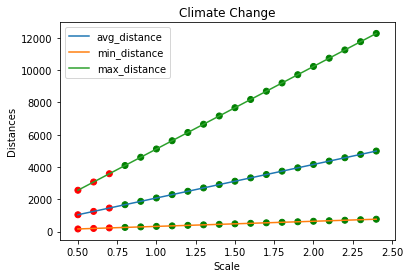

In [18]:
plot_distance_vs_scale(df)